In [1]:
import numpy as np
import sys
import math
import itertools
import matplotlib.pyplot as plt  
import networkx as nx
from pqdict import pqdict
from collections import deque

# Camínos mínimos

# _Single Source Shortest Path_

## 8.1 Introducción

Dado un digrafo pesado, la distancia de un camino es la suma de pesos de los ejes que lo componen:
$$
w (p) = \sum_{i = 1}^{k} w(v_{i-1} v_{i})
$$

Y utilizaremos el símbolo $δ$ para referirnos al camíno mínimo entre 2 vértices:
$$
δ(u, v) = 
 \begin{cases}
min \{ w(p): u \leadsto v \}, \qquad \qquad \quad  \text{si hay un camino entre } u \text{ y } v
\newline
\infty , \qquad \ \text{otherwise} 
\end{cases}
$$

Así, cualquier camino entre $u$ y $v$ con peso $w(p) = δ(u, v)$, es un camino mínimo.

Ya hemos visto un algoritmo que resuelve *uno de los problemas* de camino mínimo: BFS. La salvedad es que BFS sólo resuelve el problema de camíno mínimo entre un vértice y el resto de los vértices de un grafo no pesado, en el que sólo es cuestión de minimizar los ejes atravesados. Veremos más adelante, algoritmos que pueden responder esta pregunta para cualquier conjunto arbitrario de pesos.

Y por qué decimos que hay más de un problema de camino mínimo? Esta es una clasificación posible:

1. Camino mínimo entre 2 vértices.
2. Camino mínimo entre 1 vértices y el resto.
3. Camino mínimo entre todos los vértices.

Como las complejidades de los algoritmos que resuelven el primer problema son similares a las complejidades de los algoritmos que resuelven el segundo problema, haremos caso omiso de este primer problema y nos enfocaremos en el *2* y *3*. Es decir, si queremos hallar la distancia mínima entre 2 vértices, simplemente hallaremos la distancie entre uno de esos vértices y el resto, y luego recuperaremos la distancia que nos interesaba originalmente.

### Subestructura óptima

Todos los algoritmos que veremos se basarán en una propiedad que tienen los caminos mínimos, que no comprobaremos aquí: 
**el problema de hallar el camino mínimo tiene subestructura óptima**, es decir, los caminos óptimos contienen subcaminos óptimos.
Si el camino óptimo entre $u$ y $v$ pasa por el vértice $w$, entonces contiene el camino óptimo entre $u$ y $w$ y entre $w$ y $v$.

### Ciclos

En la introducción a grafos nombramos a los caminos y a los caminos simples, aquellos que no pasan más de 1 vez por un mismo vértice.
A qué grupo pertenecen los caminos óptimos? 

1. Ciclos netamente positivos: un camino óptimo no tendrá éste tipo de ciclos ya que sólo aumentan la distancia del camino, sin avanzarlo.
2. Ciclos neutros: todo camino óptimo que contenga un ciclo de distancia neutra puede ser reemplazado por un camino que elimine ese ciclo.
3. Ciclos netamente negativos: éstos presentan un particular problema que veremos a continuación. Vuelven inestables a los algoritmos de camino mínimo, y no permiten hallar caminos mínimos bien definidos.

En resumen, los caminos óptimos son caminos simples. No contienen ciclos de ningún tipo, por lo que su largo máximo será de $n-1$.

### Ejes y ciclos negativos

Por empezar, no todo algoritmo de caminos mínimos es aplicable a grafos con ejes de peso negativo. El algoritmo de Dijkstra es un algoritmo _greedy_ es uno de estos, mientras que el de Bellman-Ford si es aplicable a grafos con ejes de peso negativo, pero ningún algoritmo tolera ciclos de peso negativo neto.

La razón es simple, si existe un ciclo negativo dentro de un camino que una a 2 vértices cualesquiera (en la figura, entre el nodo `s` y los nodos `e`, `f` y `g`), entonces todo algoritmo que quiera minimizar el costo de ese camino, se encerrará en un _loop_ dentro de este ciclo y a cada nueva iteración encontrará un nuevo camino de menor costo que le da otra vuelta a este ciclo. Así diremos que el costo del camino mínimo hacia esos vértices será de $-\infty$ y que, por lo tanto, el camino mínimo no está definido.

Entonces, existen grafos que pueden "romper" nuestros algoritmos. Qué podemos hacer para detectarlos? Ustedes responderán esta pregunta más adelante.

<img src="ciclos_negativos.png" alt="mm" style="width: 600px;"/>

-----

## 8.2 Bellman-Ford

Por claridad, vamos a definir 2 funciones que usaremos en Bellman-Ford y luego en Dijsktra.

La primera función es una simple inicialización del grafo y de nuestro nodo fuente (ya que estamos en _single source_). Esta inicialización es idéntica a la inicialización que hace BFS.

Nótese los valores iniciales de las distancias. El nodo fuente tiene una distancia nula, ya que esta es la distancia a si mismo, y el resto de los nodos tienen una distancia $\infty$. Este es un valor inicial que luego será minimizado en la siguiente función.

In [31]:
def inicializar_single_source(G, fuente):
    for v in G.nodes():
        G.nodes[v]["predecesor"] = None
        G.nodes[v]["distancia"] = np.inf
    G.nodes[fuente]["distancia"] = 0

La segunda es la función de relajación u optimización de nodo. Cada vez que tengamos un par de vértices adyacentes `u` y `v`, nos preguntaremos si para llegar a `v` conviene pasar por `u`.

Para determinar esto, `optimizar()` compara el costo actual para llegar a `v`, con el costo de llegar a `u`, más el peso del eje que los une (el eje `(u, v)`).
Si esta condición se cumpliera, modificaremos el camino para llegar a `v`, para que pase por `u` (actualizando el predecesor de `v`), y el costo de llegar a `v` con el nuevo y más bajo valor.

In [32]:
def optimizar(G, u, v, peso):
    if G.nodes[v]["distancia"] > (G.nodes[u]["distancia"] + peso):
            G.nodes[v]["predecesor"] = None
            G.nodes[v]["distancia"] = G.nodes[u]["distancia"] + peso

Veamos ahora nuestra implementación de Bellman-Ford. 

 * línea `2`: inicializa el grafo
 * líneas `4` y `5`: recorre todos los ejes e intenta optimizar el camino hacia todos los vértices.

Aquí vemos el sentido de inicializar a los nodos con una `distancia` $\infty$. Cuando se evalue por primera vez a un eje (`u`, `v`), donde `u` tenga una `distancia` definida (no $\infty$), el camino a `v` será necesariamente optimizado, ya que cualquier valor será menor a $\infty$.

Por ejemplo, observando el grafo de la figura anterior, si el eje `(a, b)` fuera el primero en evaluarse, nada sucedería, ya que la `distancia` a ambos vértices es $\infty$. Sin embargo, cuando se evalue el eje `(s, a)`, se optimizará el nodo `a` (que pasará a tener una `distancia` de $3$), y éste a su vez podrá optimizar a `b`, que pasará a tener una `distancia` de $-1$.
 
 * línea 3: la operación anterior se repite $n-1$ veces. Este se debe a que Bellman-Ford lidia con grafos que pueden tener ejes negativos, por lo que pueden existir caminos de hasta $n-1$ ejes. A cada iteración, Bellman-Ford garantiza caminos óptimos de largo 1, luego de largo 2, 3, y así... 
 
 *CUIDADO*: nos referimos al largo del camino óptimo, por lo tanto, a la **distancia** entre el nodo fuente y cada nodo, y esta distancia no es evidente a simple vista, por eso la estamos calculando. Por ejemplo, que un nodo sea adyacente al nodo fuente, no quiere decir que su camino y distancia óptimos serán determinados en la primera iteración de las líneas `4` y `5`, ya que el camino óptimo desde la fuente podría recorrer todo el resto del grafo hasta llegar a ese mismo nodo. Por eso, sólo tendremos la garantía de haber obtenido el camino óptimo luego de la iteración $n-1$.

 Ese es el algoritmo de Bellman-Ford. Las líneas `7-11` realizan una tarea extra. 

#### **CONSIGNA** 

Qué tarea extra está haciendo nuestra implementación? Parece que está evaluando las distancias óptimas de los ejes, pero por qué? Habíamos dicho que en un grafo bien portado las distancias óptimas ya estaban resueltas con $n-1$ iteraciones. Qué busca con esa iteración extra?

In [74]:
def bf(G, fuente):
    inicializar_single_source(G, fuente)
    for v in G.nodes():
        for u, v, att in G.edges(data = True):
            optimizar(G, u, v, att["weight"])
    
    for u, v, att in G.edges(data = True):
        if G.nodes[v]["distancia"] > (G.nodes[u]["distancia"] + att["weight"]):
            return False

    return True

Apliquemos nuestro algoritmo a este digrafo ejemplo

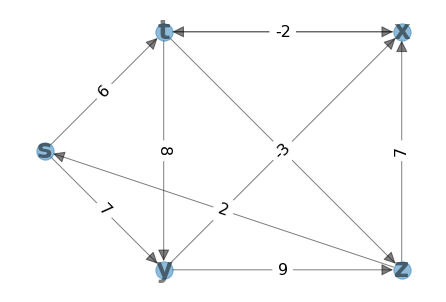

In [75]:
G = nx.DiGraph()
G.add_weighted_edges_from([("s", "t", 6), ("s", "y", 7),
("t", "x", 5), ("t", "y", 8), ("t", "z", -4), ("y", "x", -3),
("y", "z", 9), ("x", "t", -2), ("z", "x", 7), ("z", "s", 2) ])

pos = nx.spring_layout(G, seed=20)
pos["s"] = [-1, 0]
pos["t"] = [-.5, 1]
pos["x"] = [.5, 1]
pos["y"] = [-.5, -1]
pos["z"] = [.5, -1]

labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels = True, alpha = .5,
font_size = 26, font_weight = 'bold', arrowsize = 25)
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size = 16)

El dibujo del Cormen es más claro:

<img src="bellman_ford.png" alt="mm" style="width: 300px;"/>

In [76]:
bf(G, "s")

True

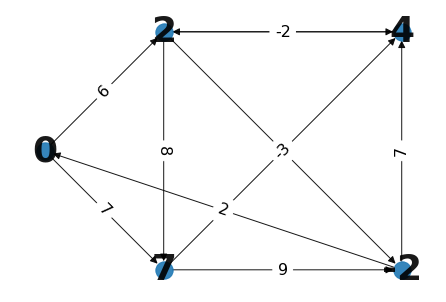

In [77]:
distancias = {}
distancias["s"] = G.nodes["s"]["distancia"]
distancias["t"] = G.nodes["t"]["distancia"]
distancias["x"] = G.nodes["x"]["distancia"]
distancias["y"] = G.nodes["y"]["distancia"]
distancias["z"] = G.nodes["z"]["distancia"]

nx.draw(G, pos, labels = distancias,with_labels = True, alpha = .9,
font_size = 36, font_weight = 'bold', arrowsize = 15)
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size = 16)

#### **CONSIGNA** 

Tenemos las distancias óptimas. Resta obtener los caminos óptimos. Cómo se recuperarían?

Piensen un algoritmo para obtener los caminos óptimos a partir de los datos calculados en nuestra implementación de Bellman Ford. Escriban sus ideas en pseudocódigo. No intenten codearlo en Python!

## Complejidad

La complejidad de Bellman-Ford es fácil de determinar. 

Bellman-Ford empieza con una inicialización de los vértices de $O(n)$, pero asumiendo un grafo conexo, ésta rutina no debería ser dominante.

Las líneas `3-5` son las que dominan el tiempo de ejecución con una línea de $O(1)$ (`5`) dentro de un ciclo de $n$ iteraciones (`4`) dentro de uno de $m$ (`3`), por lo que la complejidad de Bellman-Ford es de $O(mn)$. 

--------

## 8.3 Dijkstra

Al asumir que no hay ejes de peso negativo, Dijkstra puede asumir que si halló un camino óptimo de longitud $k$ hacia un vértice cualquiera, entonces ese es el camino óptimo global, ya que un camino de mayor longitud no tendrá un costo menor sino que a lo sumo tendrá el mismo costo, si sólo se incorporaran ejes de peso nulo.

Así, Dijkstra sigue una estrategia avara, muy similar a la del algoritmo de Prim (se recomienda mirar las 2 implementaciones a la vez). Ambos tienen una cola de prioridad con los vértices que no se han resuelto aún y una vez que un vértice sale de esa cola, ya pertenece al conjunto de vértices resuelto. La diferencia radica en la forma de avanzar la frontera de lo resuelto.

Prim puede avanzar esta frontera a través de cualquier eje que la atraviesa, sólo se preocupará por elegir el de menor peso. En este avance, se pierde la noción de camino, ya que ésto no le interesa a Prim. Dijkstra avanza a través del nodo más cercano (el de menor distancia a la fuente), minimizando el camino que se recorre hacia cada nodo, en vez de minimizar la suma global de pesos. 

Al igual que Prim, Dijkstra utiliza una cola de mínima prioridad. Ésta ordenará a los vértices de acuerdo con su distancia a la fuente, de modo que el primer elemento (nodo) a extraer sea siempre el más bajo (el más cercano a la fuente).

Adaptaremos nuestras funciones `inicializar_single_source()` y `optimizar()` para incluir esta cola y repetiremos, por claridad, la información de esta cola (la distancia a cada nodo), en el atributo `distancia` de cada nodo.
Esto no es necesario y bien podríamos anotar

In [20]:
def inicializar_single_source(G, fuente):
    Q = pqdict()
    for v in G.nodes():
        if v == fuente:
            Q[v] = 0
            G.nodes[v]["predecesor"] = None
        else:
            Q[v] = np.inf
            G.nodes[v]["predecesor"] = None
    return Q

In [21]:
def optimizar(G, Q, u, v, peso):
    try:
        dist_actual = Q[v]
    except KeyError:
        # el camino mínimo de este nodo `v` ya fue resuelto.
        return
    if dist_actual > (G.nodes[u]["distancia"] + peso):
        G.nodes[v]["predecesor"] = None
        Q[v] = G.nodes[u]["distancia"] + peso

In [22]:
def dijkstra(G, fuente):
    Q = inicializar_single_source(G, fuente)
    
    while len(Q) != 0:
        u, d = Q.popitem()
        G.nodes[u]["distancia"] = d
        for v, att in G[u].items():
            optimizar(G, Q, u, v, att["weight"])

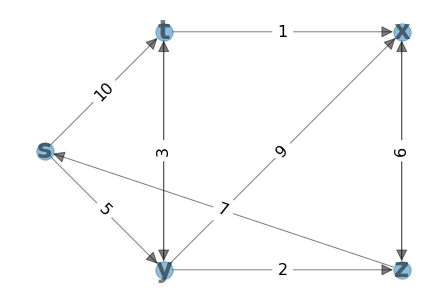

In [23]:
G = nx.DiGraph()
G.add_weighted_edges_from([("s", "t", 10), ("s", "y", 5),
("t", "x", 1), ("t", "y", 2), ("y", "t", 3),
("y", "x", 9), ("y", "z", 2), ("x", "z", 4),
("z", "x", 6), ("z", "s", 7) ])

pos = nx.spring_layout(G, seed=20)
pos["s"] = [-1, 0]
pos["t"] = [-.5, 1]
pos["x"] = [.5, 1]
pos["y"] = [-.5, -1]
pos["z"] = [.5, -1]

labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels = True, alpha = .5,
font_size = 26, font_weight = 'bold', arrowsize = 25)
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size = 16)

El dibujo del Cormen es más claro:

<img src="dijkstra.png" alt="mm" style="width: 300px;"/>

In [24]:
dijkstra(G, "s")

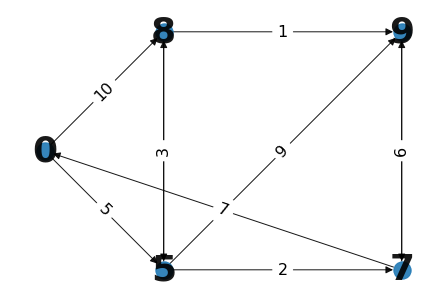

In [25]:
distancias = {}
distancias["s"] = G.nodes["s"]["distancia"]
distancias["t"] = G.nodes["t"]["distancia"]
distancias["x"] = G.nodes["x"]["distancia"]
distancias["y"] = G.nodes["y"]["distancia"]
distancias["z"] = G.nodes["z"]["distancia"]

nx.draw(G, pos, labels = distancias,with_labels = True, alpha = .9,
font_size = 36, font_weight = 'bold', arrowsize = 15)
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size = 16)

## Complejidad

La complejidad de Dijkstra es un poco más difícil de determinar y depende de la implementación de la cola de prioridad `Q`. Asumiremos que ésta es una simple _binary heap_.

Como Bellman-Ford, Dijkstra empieza con una inicialización de los vértices de $O(n)$ pero, de nuevo, asumiremos un grafo conexo, y descartaremos esta rutina como dominante.

Al igual que BFS y Prim, Dijkstra termina recorriendo todas las adyacencias, ejecutando `optimizar()` $m$ veces. Dentro de esta función, se ajusta el valor de un item de la cola `Q`, lo que implica un reordenamiento de costo $\log(n)$. Así, la complejidad final será de $O(m\log(n))$

#### **CONSIGNA** 

Esta consigna es igual a la anterior. Cómo recuperamos los caminos óptimos? Se puede aplicar la misma estrategia que en Bellman-Ford?

---

# _All Pairs Shortest Path_

En principio, podríamos repetir nuestros algoritmos de camino mínimo _single source_ $n$ veces.
Si podemos asumir que nuestro grafo no tiene ejes de peso negativo, ejecutaremos Dijkstra $n$ veces y así obtendríamos nuestra respuesta en $O(nm\log(n))$, si no, lo haremos con Bellman-Ford en $O(n^{2}m)$, que en el caso de un grafo denso (un grafo con muchos ejes por nodo, completo o casi completo), se aproximaría a $O(n^{4})$; muy costoso.

Estudiaremos ahora un algoritmo para hacer esta tarea en $O(n^{3})$.

Otro aspecto a notar es que resultado que buscamos ahora es de una dimensión mayor. Si antes teníamos una `distancia` y un `predecesor` por cada nodo, ahora tendremos $n-1$ `distancia`s y `predecesor`es por cada nodo. Así, el resultado final no será una lista de distancias y otra de predecesores, sino que obtendremos una matriz de distancias y una de predecesores, con una fila (o columna), para cada camino entre un par de vértices.

## 8. 5 Floyd-Warshall

Floyd-Warshall halla los caminos óptimos entre todos los vértices de grafos que pueden incluir ejes de peso negativo pero, de nuevo, no puede haber ciclos de peso negativo.

Es un algoritmo de PD que considera el problema de hallar el camino mínimo entre cualquier par de vértices `u`, `v`, según los $k$ vértices que atraviesa el camino que une a estos vértices `u` y `v`. Estos vértices intermedios serán la variable que descomponga este problema original en subproblemas. Y lo que se preguntará en cada subproblema es si el camino óptimo entre 2 vértices, pasa por un tercer vértice intermedio.

Por ejemplo, en la figura se ve el problema de hallar el camino óptimo entre los vértices `i` y `j` pasando por los vétices `1` a `k`:

<img src="floyd-warshall.png" alt="mm" style="width: 400px;"/>

 Hay 2 opciones:
 
 * Si `k` no es vértice intermedio, entonces este camino óptimo tiene vértices intermedios en el conjunto `0:k-1`, lo cual nos achica el problema a resolver. Y si el camino óptimo está entre los vértices `0:k-1`, también lo estará dentro de los vértices `0:k`. En la resolución de este caso, no hemos descubierto un vértice del camino óptimo.

 * Si el camino óptimo `p` pasa por `k`, entonces descomponemos al camino `p(i, j)` en 2 subcaminos (subproblemas), `p1(i, k)` y `p2(k, j)`, que serán los caminos óptimos entre esos vértices indicados. Sabemos que estos son caminos óptimos por la propiedad de subestructura óptima que caracteriza al problema de camino mínimo (mencionada al principio). Además sabemos que los caminos `p1` y `p2` no incluirán a `k`, por lo que terminamos descomponiendo un camino de hasta `k` vértices en 2 subproblemas de hasta `k-1` vértices. Es decir, buscaremos a los caminos óptimos `p1` y `p2` entre los caminos que pasen por los vértices `0:k-1`. Además, hemos determinado 1 vértice del camino óptimo.

Dicho de otra forma, numeramos a los vértices de `1` a `n`. Para cada par de vértices `u`, `v` y un valor entero `k`, definimos el camino mínimo `p(u, v, k)`. Este es el camíno mínimo entre `u` y `v` que **potencialmente** pasa por los vértices `0:k`, es decir, podría pasar por un subconjunto de estos vértices. Cada subproblema contiene este camino mínimo `p(u, v, k)` para todo par `u`, `v` y un `k` definido.

Por ejemplo, el caso base es el de hallar los caminos mínimos `p(u, v, 0)`. Qué caminos mínimos pasan por 0 vértices? Los caminos mínimos que van desde un nodo hacia ese mismo nodo! Así, en la primer iteración se resuelven los caminos mínimos de todos los nodos hacia si mismos y que tienen una distancia nula. Como siempre, el caso base es un subproblema trivial, pero que reutilizaremos para resolver el siguiente subproblema (suponiendo un _approach_ _bottom-up_), `p(u, v, 1)`. Ahí sólo podremos resolver los caminos mínimos entre nodos que sean adyacentes.

En estos 2 subproblemas pequeños que hemos ilustrado sólo se hallaron los caminos mínimos de un subconjunto de pares de vértices. Qué sucede mientras tanto con los vértices cuyos caminos mínimos abarcan más de `0` o `1` vértices? Bueno, al igual que en Bellman-Ford, estos caminos tendrán una distancia teórica de $\infty$ hasta que sean resueltos.

Sólo podremos estar segures de haber resuelto los caminos mínimos entre todos los vértices una vez que hallamos resuelto el problema original. El de los caminos `p(u, v, n-1)`. Quizás en nuestro grafo no haya ningún camino míninimo tan largo, pero hasta no evaluar todos los posibles vértices intermedios para cada camino, no podremos estar seguros de tener los óptimos.

Todo esto queda plasmado en la siguiente recursión:

$$
dist(u, v, k) = 
 \begin{cases}
 w(u \rightarrow v) , \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \text{si } k = 0
 \newline
min \{ dist(u, v, k-1), \ \  dist(u, k, k-1) + dist(k, v, k-1) \}, \quad   \text{si } k \geq 1
\end{cases}
$$

Con el siguiente pseudocódigo:

<img src="floyd-warshall_2.png" alt="mm" style="width: 400px;"/>

## 8.6 Conclusión

* Estudien de la notebook, pero pasen inmediatamente a los ejercicios. El código está para ayudarles a profundizar, no para reemplazar el tiempo de ejercitación.
* Leer del Cormen: **p(643-676)**
* Leer del Cormen: **p(684-704)**

--------------------

### Contenidos a explicar durante la práctica